# Проверка гипотез по увеличению выручки в интернет-магазине

<h3> Бриф <a class="tocSkip"></h2>

Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.

<h3> Цель исследования <a class="tocSkip"></h2>

Приоритизировать гипотезы, запустить A/B-тест и проанализировать его результаты. 

<h3> План работы <a class="tocSkip"></h2>

1. Обзор данных
2. Приоритизация гипотез
3. Анализ A/B-теста
4. Анализ выбросов и всплесков
5. Проверка статистической значимости
6. Общий вывод

### Обзор данных

In [1]:
# загрузка библиотек
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

In [2]:
# чтение файлов
hypothesis = pd.read_csv('hypothesis.csv')
orders = pd.read_csv('orders.csv')
visitors = pd.read_csv('visitors.csv')

In [3]:
display(hypothesis.head())
display(orders.head())
visitors.head()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [4]:
display(hypothesis.info())
display(orders.info())
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


**Промежуточный вывод**

При осмотре данных были выявлены следующие моменты:
1. В `hypothesis` названия столбцов начинаются с заглавной буквы
2. В `orders` названия столбцов без snake_case
3. Столбцы с датами не обладают соответствующим типом данных
4. Пропусков нет.

####

### Предобработка данных

In [5]:
# змейка
orders = orders.rename(columns={
        'transactionId': 'transaction_id',
        'visitorId': 'visitor_id'
})
# приведем названия столбцов к нижнему регистру
for column in hypothesis:
    hypothesis.columns = hypothesis.columns.str.lower()
print(hypothesis.columns)

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')


In [6]:
# меняем тип данных
visitors['date'] = pd.to_datetime(visitors['date'], format = '%Y-%m-%d')
orders['date'] = pd.to_datetime(orders['date'], format = '%Y-%m-%d')
print(visitors.info())
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [7]:
# проверка на дубликаты
for table in [orders, visitors]:
    print(table.duplicated().sum())

0
0


**Изучим дополнительную информацию о данных A/B-теста**

In [8]:
# определим количество групп в тесте
visitors['group'].unique()

array(['A', 'B'], dtype=object)

Всего две группы в тесте

In [9]:
# изучим временной интервал теста
print('Дата начала проведения теста:', visitors.date.min())
print('Дата окончания проведения теста:', visitors.date.max())

Дата начала проведения теста: 2019-08-01 00:00:00
Дата окончания проведения теста: 2019-08-31 00:00:00


A/B тестирование проводилось 31 день

In [10]:
# посмотрим на количество пользователей в каждой группе
visitors.groupby('group')['visitors'].sum()

group
A    18736
B    18916
Name: visitors, dtype: int64

Группа В больше, чем группа А

In [11]:
# посмотрим не попадают ли какие-то пользователи в обе группы

groupA_orders = orders[orders['group'] == 'A'][['visitor_id', 'group']]
groupB_orders = orders[orders['group'] == 'B'][['visitor_id', 'group']]

intersection = groupA_orders.merge(groupB_orders, on='visitor_id', how='inner')

if intersection.empty:
    print('Нет пересечений по пользователям')
else:
    print('Есть пересечения по пользователям')

Есть пересечения по пользователям


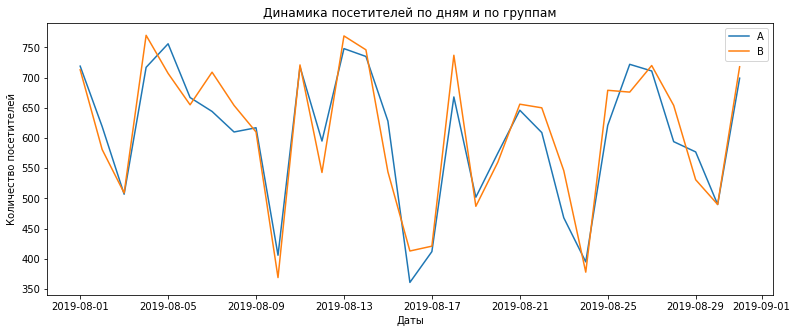

In [12]:
# посмотрим на динамику посетителей по дням и по группам

# датафрейм с количеством пользователей по дням в группе А
groupA = visitors[visitors['group']=='A'].groupby('date').agg({'visitors': 'sum'}).reset_index()

# датафрейм с количеством пользователей по дням в группе B
groupB = visitors[visitors['group']=='B'].groupby('date').agg({'visitors': 'sum'}).reset_index()

plt.figure(figsize=(13, 5))

# Строим график с количеством пользователей по дням группы А
plt.plot(groupA['date'], groupA['visitors'], label='A')

# Строим график с количеством пользователей по дням группы B
plt.plot(groupB['date'], groupB['visitors'], label='B')

plt.legend()
plt.title('Динамика посетителей по дням и по группам')
plt.xlabel('Даты')
plt.ylabel('Количество посетителей');

По графику нельзя точно определить, пользователи из какой группы чаще заходят на сайт интернет-магазина.

####

### Приоритизация гипотез

In [13]:
# применим к гипотезам фреймворк ICE
pd.set_option('max_colwidth', 110)

hypothesis['ice'] = (hypothesis.impact * hypothesis.confidence) / hypothesis.efforts

round(hypothesis[['hypothesis', 'ice']].sort_values('ice', ascending=False), 2)

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Самыми "важными" гипотезами по фреймворку ICE получились:
1. Запустить акцию, дающую скидку на товар в день рождения (ice 16.2)
2. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей (ice 13.33)
3. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок (ice 11.2)

In [14]:
# применим к гипотезам фреймворк RICE

hypothesis['rice'] = (hypothesis.reach * hypothesis.impact * hypothesis.confidence) / hypothesis.efforts

round(hypothesis[['hypothesis', 'rice']].sort_values('rice', ascending=False), 2)

,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


In [15]:
hypothesis.sort_values('reach', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ice,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.2


Видим, что при добавлении критерия охвата приоритетность гипотез поменялась. Лидируют теперь гипотезы:
1. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок (112.0)
2. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа	(56.0)
3. Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар (9.0)

Для первой гипотезы параметр охвата поставлен максимальным, далее идет вторая по силе критерия гипотеза с оценкой в 8 баллов для критерия охвата.

####

### Анализ A/B-теста

**График кумулятивной выручки по группам**

In [16]:
# создаем массив уникальных пар значений дат и групп теста
date_groups = orders[['date','group']].drop_duplicates()

# соберём агрегированные кумулятивные по дням данные о заказах
orders_agg = date_groups.apply(
    lambda x: orders[
        np.logical_and(orders["date"] <= x["date"], orders["group"] == x["group"])
    ].agg(
        {
            "date": "max",
            "group": "max",
            "transaction_id": "nunique",
            "visitor_id": "nunique",
            "revenue": "sum",
        }
    ),
    axis=1,
).sort_values(by=["date", "group"])

# соберём агрегированные кумулятивные по дням данные о пользователях
visitors_agg = date_groups.apply(
    lambda x: visitors[
        np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])
    ].agg(
        {
            'date' : 'max', 
            'group' : 'max', 
            'visitors' : 'sum'
        }
    ), 
    axis=1
).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulative_df = orders_agg.merge(visitors_agg, on=['date', 'group'])
cumulative_df.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulative_df.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


In [17]:
# проверим корректно ли создан датафрейм cumulative_df
print(cumulative_df.date.min())
print(cumulative_df.date.max())

2019-08-01 00:00:00
2019-08-31 00:00:00


Даты проведения тестирования в cumulative_df совпадают с датами в исходном файле

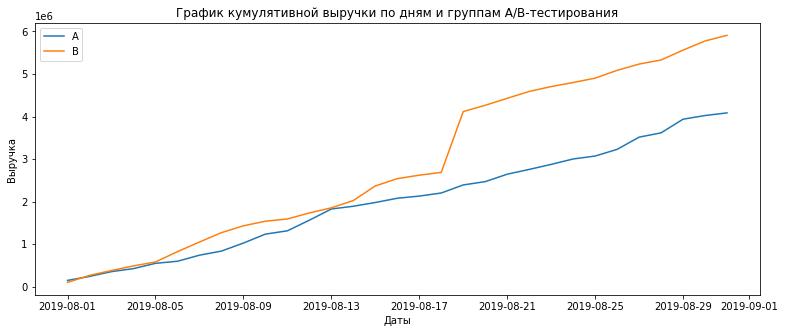

In [18]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulative_df[cumulative_df['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulative_df[cumulative_df['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(13, 5))

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.legend()
plt.title('График кумулятивной выручки по дням и группам A/B-тестирования')
plt.xlabel('Даты')
plt.ylabel('Выручка');

**Выводы**

1. Выручка почти равномерно увеличивается в течение всего теста.
2. График выручки группы В резко растет в одной точке. Причиной этому может быть резкий всплеск числа заказов или же увеличение среднего чека группы В. Также резкий рост выручки в группе В может быть связан с аномальными значениями, выбросами.
3. Пока что по графику можно сказать, что группа В приносит больше выручки, чем группа А.

**График кумулятивного среднего чека по группам**

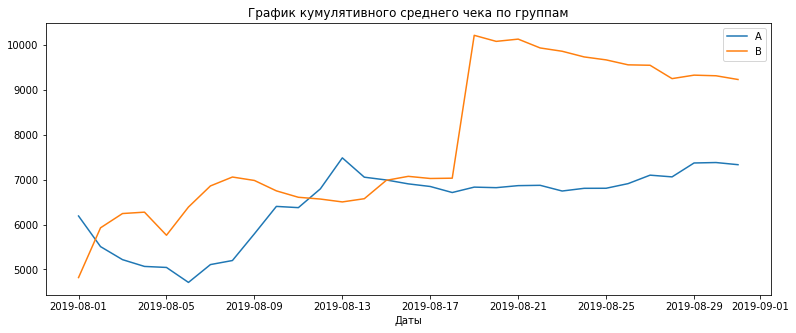

In [19]:
plt.figure(figsize=(13, 5))

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

plt.legend()
plt.title('График кумулятивного среднего чека по группам')
plt.xlabel('Даты');

**Выводы**

1. В начале тестирования графики обеих групп нестабильны, заметны резкие скачки
2. На графике кумулятивной выручки группы В был резкий рост выручки в районе 18 августа, также и на графике кумулятивного среднего чека виден резкий скачок. Возможно высокий средний чек в выборке связан с тем, что в этот день было большое число заказов или магазин разместил более дорогие товары.
3. Средние чеки обеих групп к концу становятся равномернее и стабильнее, но видна тенденция к снижению в группах
4. С учетом аномальных значений средний чек В выше, чем А

**График относительного изменения кумулятивного среднего чека группы B к группе A**

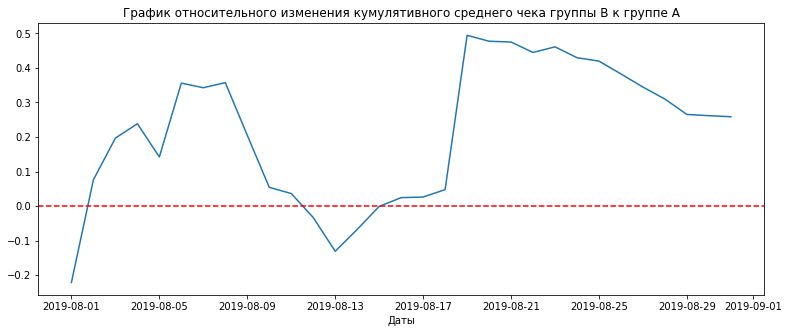

In [20]:
# собираем данные в одном датафрейме
merged_cumulative_revenue = cumulativeRevenueA.merge(
    cumulativeRevenueB, on='date', how='left', suffixes=['A', 'B']
)

plt.figure(figsize=(13, 5))

# cтроим отношение средних чеков
plt.plot(
    merged_cumulative_revenue['date'],
    (merged_cumulative_revenue['revenueB'] / merged_cumulative_revenue['ordersB'])
    / (merged_cumulative_revenue['revenueA'] / merged_cumulative_revenue['ordersA'])
    - 1,
)
# добавляем ось X
plt.axhline(y=0, color='red', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('Даты');

**Вывод**

В нескольких точках график различия между группами резко скачет. Значит действительно имеют место быть аномальные значения и выбросы.

**График кумулятивного среднего количества заказов на посетителя по группам**

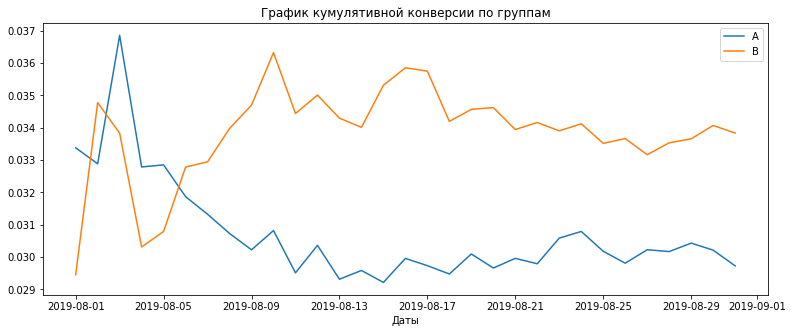

In [21]:
# считаем кумулятивную конверсию
cumulative_df['conversion'] = cumulative_df['orders']/cumulative_df['visitors']

# отделяем данные по группе A
cumulative_A = cumulative_df[cumulative_df['group']=='A']

# отделяем данные по группе B
cumulative_B = cumulative_df[cumulative_df['group']=='B']

# строим графики
plt.figure(figsize=(13, 5))

plt.plot(cumulative_A['date'], cumulative_A['conversion'], label='A')
plt.plot(cumulative_B['date'], cumulative_B['conversion'], label='B')
plt.legend()
plt.title('График кумулятивной конверсии по группам')
plt.xlabel('Даты');

**Выводы**

1. В первые дни конверсия группы А выше, чем у В, что позже изменяется
2. В целом кумулятивная конверсия в покупку у группы В выше, чем у А
3. В конце кумулятивная конверсия у обеих групп снижается

**График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A**

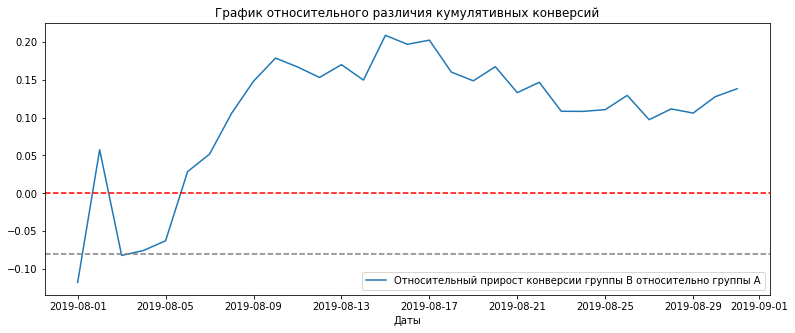

In [22]:
merged_cumulative_cr = cumulative_A[['date', 'conversion']].merge(
    cumulative_B[['date', 'conversion']],
    on='date',
    how='left',
    suffixes=['A', 'B'],
)

# строим график
plt.figure(figsize=(13, 5))
plt.plot(
    merged_cumulative_cr['date'],
    merged_cumulative_cr['conversionB'] / merged_cumulative_cr['conversionA'] - 1,
    label='Относительный прирост конверсии группы B относительно группы A',
)
plt.legend()

plt.axhline(y=0, color='red', linestyle='--')
plt.axhline(y=-0.08, color='grey', linestyle='--')
plt.title('График относительного различия кумулятивных конверсий')
plt.xlabel('Даты');

**Выводы**

В начале теста группа B проигрывала группе A (видны резкие снижения в течение первых 5ти дней), затем вырвалась вперёд. Потом её конверсия показывает резкий рост, также в конце тестирования она постепенно растёт.

**Промежуточные выводы по данным А/B-теста**



**Выручка**: В начале теста группы имели примерно одинаковую выручку, но группа В впоследствии вырвалась вперед, возможно из-за резкого всплеска числа заказов. По итогам теста группа В приносит больше выручки, чем группа А.

**Средний чек**: Графики кумулятивного среднего чека также показывают резкие скачки, возможно, вызванные аномально большими заказами или изменениями в ассортименте товаров. В целом, средний чек в группе В оказался выше, чем в группе А, но наблюдаются тенденции к снижению среднего чека в обеих группах к концу теста.

**Конверсия**: В начале теста группа А имела более высокую конверсию, но затем группа В вырвалась вперед и продолжала расти. В конечном итоге, кумулятивная конверсия в покупку оказалась выше у группы В. Конверсия в обеих группах снижалась к концу теста.

**Резкие скачки и аномалии**: Наличие резких скачков на графиках выручки, среднего чека и конверсии свидетельствует о наличии аномалий или выбросов в данных. Эти аномалии могут исказить результаты теста и требуют дополнительного анализа.

####

### Анализ выбросов и всплесков

**График количества заказов по пользователям**

In [23]:
# создадим сводную таблицу с колическом заказов по каждому пользователю 
orders_count = (
    orders.groupby('visitor_id')
    .agg({'transaction_id': 'nunique'})
)
orders_count.columns = ['count']
orders_count.sort_values(by='count', ascending=False).head()

,count
visitor_id,
4256040402,11
2458001652,11
2378935119,9
2038680547,8
199603092,5


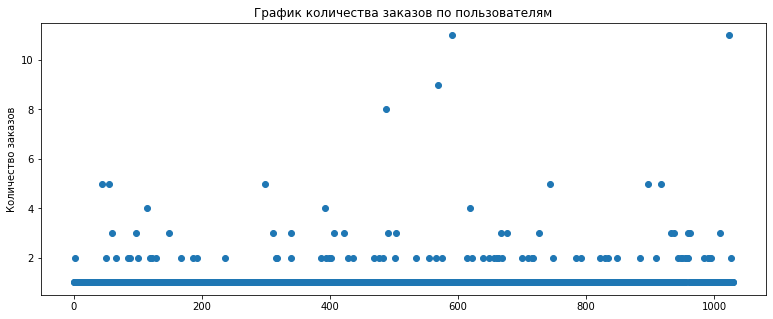

In [24]:
# точечный график количества заказов по пользователям
plt.figure(figsize=(13, 5))
x_values = pd.Series(range(0,len(orders_count['count'])))
plt.scatter(x_values, orders_count['count'])
plt.title('График количества заказов по пользователям')
plt.ylabel('Количество заказов');

**Выводы**
1. Большинство значений колеблятся вокруг 1 и 2 заказов, и плотность графика естественное убывает с увеличением количества заказов.
2. Присутствуют выбросы: 2 пользователя сделали по 11 заказов, также есть значения в 9 и 8 заказов.

Посчитаем 95-й и 99-й перцентили количества заказов на пользователя и выберем границу для определения аномальных пользователей.

In [25]:
np.percentile(orders_count['count'], [95, 99])

array([2., 4.])

**Выводы**
1. Не более 5% пользователей оформляли больше 2 заказов
2. Не более 1% пользователей заказывали больше 4 раз
3. Значит границей нормальных пользователей определим 4 заказа

**График стоимость заказов по пользователям**

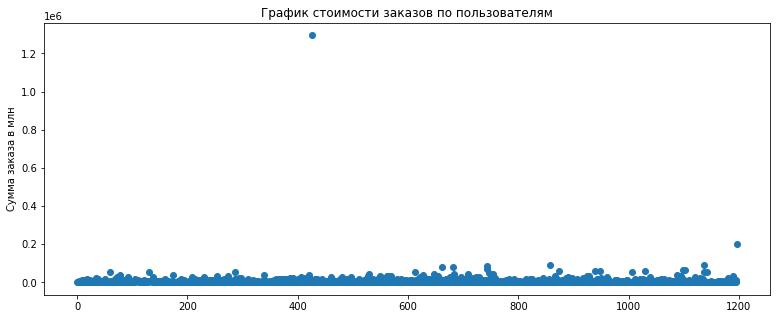

In [26]:
# точечный график стоимости заказов
plt.figure(figsize=(13, 5))
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title('График стоимости заказов по пользователям')
plt.ylabel('Сумма заказа в млн');

Видно, что значение 1.2 и 0.2 млн руб сильно выбиваются из общей массы заказов

Посмотри на распредление стоимости заказов по пользователям, отбросив выбросы

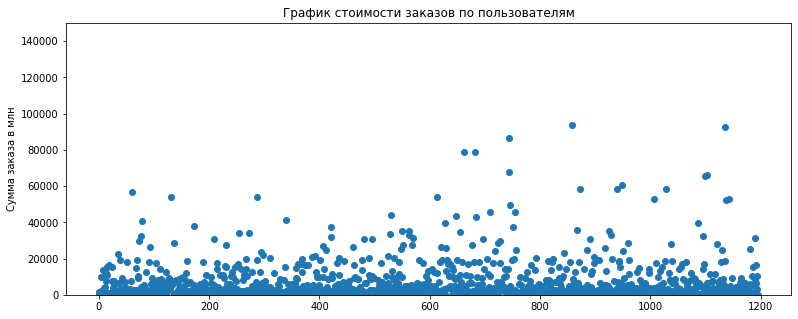

In [27]:
# точечный график стоимости заказов
plt.figure(figsize=(13, 5))
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.ylim(0, 150000)
plt.title('График стоимости заказов по пользователям')
plt.ylabel('Сумма заказа в млн');

По данным, очищенным от выбросов, видим, что стоимость большинства заказов < 20 000.

Посчитаем 95-й и 99-й перцентили стоимости заказов ивыберем границу для определения аномальных заказов

In [28]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

**Вывод**

Не более 5% заказов дороже 28 000 рублей и не более 1% дороже 58 233.2 рублей.

Определим границу для аномальных заказов в 28 000 рублей.

### Проверка статистической значимости

Посчитаем статистическую значимость различий в среднем числе заказов на пользователя и среднем чеке между группами по «сырым» данным — без удаления аномальных пользователей и по "очищенным" данным. 

Уровень значимости примем за 5%.

**Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным**

Гипотезы

**Нулевая**: различий в среднем количестве заказов между группами нет. 

**Альтернативная**: различия в среднем между группами есть.

In [29]:
# создадим переменные, в которых будут пользователи, совершившие хотя бы 1 заказ
orders_users_a = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_users_a.columns = ['visitor_id', 'orders']

orders_users_b = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_users_b.columns = ['visitor_id', 'orders']

In [30]:
# объявим переменные sample_a и sample_b, в которых пользователям из разных групп будет соответствовать количество заказов
sample_a = pd.concat(
    [
        orders_users_a['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors[visitors['group'] == 'A']['visitors'].sum() - len(orders_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b = pd.concat(
    [
        orders_users_b['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors[visitors['group'] == 'B']['visitors'].sum() - len(orders_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [31]:
# применим критерий Манна-Уитни и отформатируем p-value, округлив его до трёх знаков после запятой

print('p_value =', '{0:.3f}'.format(stats.mannwhitneyu(sample_a, sample_b)[1]))

print('Относительный прирост среднего числа заказов группы B =', '{0:.3f}'.format(sample_b.mean() / sample_a.mean() - 1))

p_value = 0.017
Относительный прирост среднего числа заказов группы B = 0.138


**Выводы**
1. P_value меньше 0.05, значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, отвергаем, различия есть. 
2. Относительный выигрыш группы B равен 13.8%

**Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным**

Гипотезы

**Нулевая**: различий в среднем чеке между группами нет. 

**Альтернативная**: различия в среднем чеке между группами есть. 

In [32]:
print(
    'p_value =', 
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[orders['group']=='A']['revenue'],
            orders[orders['group']=='B']['revenue'])[1]
    )
)

print(
    'Относительный прирост среднего чека группы В =',
    '{0:.3f}'.format(
        orders[orders['group']=='B']['revenue'].mean()
        /orders[orders['group']=='A']['revenue'].mean()
        -1
    )
)

p_value = 0.729
Относительный прирост среднего чека группы В = 0.259


**Выводы**
1. P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет.
2. При этом средний чек группы B выше среднего чека группы A на 25.9%
3. Поскольку относительное различие среднего чека между сегментами составляет около 26%, наблюдаемые различия не являются значимыми при заданном уровне значимости в 5%, а следовательно были получены случайно.

**Cтатистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным**

Примем за аномальных пользователей тех, кто совершил от 3 заказов или совершил заказ дороже 28 000 рублей. Так мы уберём от 1% до 5% пользователей с наибольшим числом заказов и 5% пользователей с дорогими заказами.

In [33]:
# вычисление 99-го процентиля для количества заказов
orders_99 = np.percentile(orders_count['count'], 99)

users_many_orders = pd.concat(
    [
        orders_users_a[orders_users_a['orders'] > orders_99]['visitor_id'],
        orders_users_b[orders_users_b['orders'] > orders_99]['visitor_id'],
    ],
    axis=0,
)
# вычисление 95-го процентиля для столбца 'revenue'
revenue_95 = np.percentile(orders['revenue'], 95)

# выбираем все строки, где 'revenue' больше 95-го процентиля
users_expensive_orders = orders[orders['revenue'] > revenue_95]['visitor_id']

abnormal_users = (
    pd.concat([users_many_orders, users_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)
abnormal_users.head()

1099    148427295
928     204675465
684     358944393
648     382846391
1189    393266494
Name: visitor_id, dtype: int64

In [34]:
# отфильтруем переменные
sample_a_filt = pd.concat(
    [
        orders_users_a[
            np.logical_not(orders_users_a['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors[visitors['group'] == 'A']['visitors'].sum() - len(orders_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b_filt = pd.concat(
    [
        orders_users_b[
            np.logical_not(orders_users_b['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors[visitors['group'] == 'B']['visitors'].sum() - len(orders_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [35]:
# применим статистический критерий Манна-Уитни к полученным выборкам
print(
    'p_value =', 
      '{0:.3f}'.format(
          stats.mannwhitneyu(sample_a_filt, sample_b_filt)[1]
      )
     )
print(
    'Относительный прирост среднего чека группы В =',
      '{0:.3f}'.format(
          sample_b_filt.mean()
          /sample_a_filt.mean()-1
      )
     )

p_value = 0.018
Относительный прирост среднего чека группы В = 0.145


**Выводы**
1. P_value меньше 0.05, значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, все же отвергаем. 
2. Относительный выигрыш группы B равен 14.5%, что выше по сравнению с "сырыми данными" на почти 1%

**Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным**

In [36]:
print(
    'p_value =',
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    'Относительный прирост среднего чека группы В =',
    '{0:.3f}'.format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        - 1
    )
)

p_value = 0.961
Относительный прирост среднего чека группы В = -0.014


**Выводы**
1. P-value значительно больше 0.05 и увеличился после очистки от аномалий. В любом случае, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет.
2. Относительный проигрыш по среднему чеку группы В получился 1%, что кардинально отличается от значения почти в 26% в "сырых данных"

### Общий вывод

Имеющиеся факты:
1. Есть статистически значимое различие по среднему количеству заказов между группами и по «сырым», и по данным после фильтрации аномалий
2. Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;
3. График различия среднего количества заказов между группами сообщает, что результаты группы B лучше группы A
4. График различия среднего чека говорит о том, что результаты группы B лучше чем у А

Исходя из обнаруженных фактов, тест следует остановить. Лучшие результаты в выручке, конверсии и по среднему количеству заказов показывает группа В, но по отфильтрованным данным по среднему чеку между группами группа В проигрывает группе А на 2%, что следует иметь в виду.